# Protein Binding

In [2]:
import pandas as pd
import numpy as np
from sklearn import manifold
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
%matplotlib inline
from Bio.PDB import *
import gudhi as gd

This notebook aims to reproduce the results of: 
 - Kovacev-Nikolic V, Bubenik P, Nikolić D, Heo G. _Using persistent homology and dynamical distances to analyze protein binding._ Statistical Applications in Genetics and Molecular Biology, 15(1). (2016)

This papers develops a clsssification algorithm of different shapes of teh protein **MBP (maltose-binding protein)** basado en el cálculo de Homología Persistente.


![SegmentLocal](figures/animated_Maltose-binding_protein_b.gif "segment") 

Figure: E. coli maltose-binding protein complex with maltose (PDB entry 1anf) .

### 1. The problem


The **maltose-binding protein**) is a bacterian protein present in **Escherichia-coli**.

Its main function is to **unir y transportar moléculas de azúcar** a través de las membranas celulares, proporcionando energía a la bacteria (Boos y Shuman, 1998).

Aunque a veces causan enfermedades graves, la mayoría de las cepas de E. coli no son patógenas y de hecho son beneficiosas. Estas bacterias colonizan el tracto gastrointestinal de humanos y animales y protegen el intestino de bacterias dañinas (Hudault et al., 2001). Además, **E. coli** es el organismo vivo más conocido y **se utiliza para estudiar varios procesos celulares** (Van Houdt y Michiels, 2005). 

Cuando una molécula más pequeña, llamada **ligando**, se une a la molécula de proteína, se produce un cambio _conformacional_  en la proteina.
Szmelcman et al. (1976) determinaron que la MBP interactúa con varias moléculas de azúcar (ligandos), comenzando desde la pequeña molécula de maltosa hasta la maltodextrina más grande. Los **cambios conformacionales** inducidos son importantes porque **la función biológica de la proteína** ocurre a través de una transición de una estructura libre de ligando (apo) a una estructura unida a ligando (holo) (Seeliger y de Groot, 2010). 

Simulaciones y experimentos muestran que el 95% de las veces los dos dominios de MBP están separados y retorcidos, lo que se denomina conformación **abierta**, y el 5% de las veces están cerca uno del otro, lo que se denomina conformación **cerrada**. Si está cerrado, siempre se debe a que tiene un ligando capturado. Las estructuras abiertas pueden tener un ligando adjunto o no.


![title](figures/open-closed.png)

Figure from _Maltose-binding protein: a versatile platform for prototyping biosensing._ Curr Opin Biotechnol. 2006 Feb;17(1):17-27

### 2. The data

Se estudiaron distintas **estructuras tridimensionales** de la proteina MBP, obtenidas por **cristalografía de rayos X**. Las estructuras están disponibles en **Protein Data Bank**, Bernstein et al. (1977). 

Cada estructura es una biomolécula grande con aproximadamente 3000 átomos pesados agrupados en **370** grupos relativamente pequeños que representan **residuos de aminoácidos**. En lugar de utilizar un modelo de todos los átomos, utilizamos un modelo de grano grueso (coarsed-grain model) en el que cada residuo está representado por una sola unidad (Cavasotto et al., 2005).  


**Ejemplo:**  https://www.rcsb.org/structure/1anf 

#### Modelo dinámico

- Nikolić, D. and V. Kovacev-Nikolic (2013). **Dynamical model of the maltose-binding protein**

Las coordenadas tridimensionales obtenidas por **cristalografía de rayos X** dan una **estructura estática**. Sin embargo, esta **estructura** depende del tiempo y es **inestable**. Entonces, un descriptor dinámico es más apropiado. 

Modelamos la dinámica de la estructura de la proteína utilizando un **modelo de red elástica** (Atilgan et al., 2001, Tobi y Bahar, 2005). Aunque todos los componentes de la proteína exhiben constantemente pequeñas oscilaciones debido al movimiento térmico, los movimientos a mayor escala ocurren porque las unidades vecinas se afectan fuertemente entre sí.
**La proteína se modela como un sistema dinámico de perlas unidas por resortes elásticos** con una distancia de corte de 15 Å.



### 3. Métrica de correlación

El análisis no está basado en el embedding de la proteína en $\mathbb R^3$ con la distancia euclídea, sino en base a una _distancia dinámica_ entre los residuos, definida por: 
$$D_{ij} = 1 - |C_{ij}|,$$
donde $C$ es la matriz de correlación entre los residuos.

Las matrices de correlación entre los residuos se pueden hallar en el siguiente [link](https://www.researchgate.net/publication/301543862_corr).


Veamos el ejemplo de la estructura **1anf**.

In [27]:
corr = pd.read_csv('./datasets/Corr_ProteinBinding/1anf.corr_1.txt',
                         header=None,
                         delim_whitespace=True)

In [28]:
dist = 1- np.abs(corr)

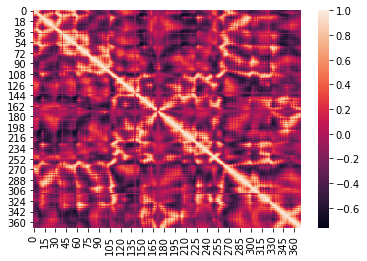

In [29]:
sns.heatmap(corr_1mdp)
plt.show()

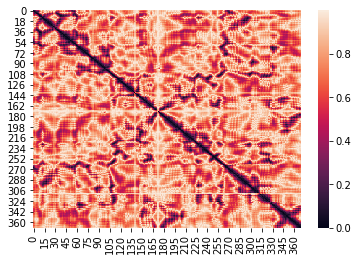

In [30]:
sns.heatmap(dist)
plt.show()

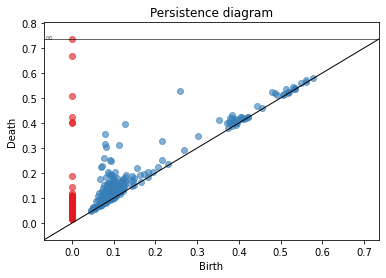

In [33]:
skeleton_protein = gd.RipsComplex(distance_matrix=dist.values,
                                  max_edge_length=0.8) 

Rips_simplex_tree_protein = skeleton_protein.create_simplex_tree(max_dimension=2)
BarCodes_Rips = Rips_simplex_tree_protein.persistence()
gd.plot_persistence_diagram(BarCodes_Rips)
plt.show()

Calculamos la matriz de distancias entre residuos de diferentes estructuras de proteinas MBP.

In [38]:
path_file = "./data/Corr_ProteinBinding/"
files_list = [
'1anf.corr_1.txt',
'1ez9.corr_1.txt',
'1fqa.corr_2.txt',
'1fqb.corr_3.txt',
'1fqc.corr_2.txt',
'1fqd.corr_3.txt',
'1jw4.corr_4.txt',
'1jw5.corr_5.txt',
'1lls.corr_6.txt',
'1mpd.corr_4.txt',
'1omp.corr_7.txt',
'3hpi.corr_5.txt',
'3mbp.corr_6.txt',
'4mbp.corr_7.txt']

corr_list = [pd.read_csv(path_file+u,
                         header=None,
                         delim_whitespace=True) for u in files_list]

dist_list = [1- np.abs(c) for c in corr_list]

Calculamos el diagrama de persistencia de cada estructura.

In [39]:
persistence_list0 = []
persistence_list1 = []

for d in dist_list:
    rips_complex = gd.RipsComplex(distance_matrix=d.values, max_edge_length=0.8)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    diag = simplex_tree.persistence()
    persistence_list0.append(simplex_tree.persistence_intervals_in_dimension(0))
    persistence_list1.append(simplex_tree.persistence_intervals_in_dimension(1))

Calculamos la distancia bottleneck entre los diagramas para cada dimension

In [40]:
l = len(files_list)
B0= np.zeros((l,l))
B1 =np.zeros((l,l))
for i in range(l):
    for j in range(i):
        B0[i,j] = gd.bottleneck_distance(persistence_list0[i], persistence_list0[j])
        B1[i,j] = gd.bottleneck_distance(persistence_list1[i], persistence_list1[j])
B0 = B0 + B0.transpose()
B1 = B1 + B1.transpose()

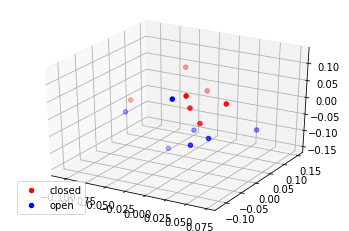

In [57]:
mds = manifold.MDS(n_components=3, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(B0).embedding_
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos[0:7,0], pos[0:7, 1],pos[0:7, 2],  color='red', label="closed")
ax.scatter(pos[7:l,0], pos[7:l, 1],pos[7:l, 2], color='blue', label="open")
ax.legend( loc=3, borderaxespad=1);

Encuentran que los diagramas correspondientes a proteínas con estructura abierta y cerrada se pueden clasificar linealmente utilizando LinearSVM.

<img src="figures/SVM.jpg" width="800">